In [1]:
import csv
from xml.etree import ElementTree
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import StrMethodFormatter
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from pyclustertend import hopkins, vat, assess_tendency_by_mean_metric_score
from sklearn.preprocessing import scale, MinMaxScaler, minmax_scale, RobustScaler,robust_scale
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
import sklearn.metrics as compute_metrics
import seaborn as sns

In [2]:
real_labels_file = "C:/Users/aprodea/work/metrics-tax-compare/analysis/labelled_data_ext.csv"
# metrics_labelled_file = "C:/Users/aprodea/work/deloitte-tax-i/analysis/last/classification/all_labels.csv"
metrics_labelled_file = "C:/Users/aprodea/work/metrics-tax-compare/analysis/tag-1.1.1/classification/1_all_labels.csv"

var_list = ['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall']
label_list = ['CLevel_threshold', 'CLevel_k_means', 'CLevel_em']

plots_save_to_location = "C:/Users/aprodea/work/metrics-tax-compare/analysis/tag-1.1.1/classification/1_plots"

def get_labelled_data():
    data = pd.read_csv(metrics_labelled_file, sep=';')
    return data

labelled_df = get_labelled_data()
labelled_df

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),14.0,3.0,0,1.0,1.0,0,2,2.0,4.0,low,low,high
1,GES_GRT.GES_GRTCoreModule.Initialize(),1.0,1.0,0,0.0,0.0,0,0,1.0,4.0,low,low,low
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),2.0,1.0,0,0.0,0.0,0,1,1.0,4.0,low,low,low
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,2.0,1.0,0,0.0,0.0,5,0,1.0,3707.0,low,low,regular
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),2.0,1.0,0,0.0,0.0,4,0,1.0,2358.0,low,low,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,8.0,1.0,1,0.0,0.0,1,3,4.0,4.0,low,low,high
751,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,3.0,2,0.0,1.0,1,2,1.0,8.0,low,low,low
752,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,6.0,2,0.0,1.0,1,2,1.0,8.0,low,low,high
753,GES_GRT.Web.App.Startup.AppNavigationProvider....,2.0,1.0,1,0.0,0.0,0,1,15.0,4.0,regular,low,high


# Using expert knowledge

In [19]:

def print_cm(cm, labels):
    """pretty print for confusion matrixes"""
    column_width = 10
    # Print header
    header = " " * column_width
    for label in labels:
        header += "%{0}s".format(column_width) % label
    print(header)
    # Print rows
    for i, label1 in enumerate(labels):
        row_text = "%{0}s".format(column_width) % label1
        for j in range(len(labels)):
            cell = "%{0}.1f".format(column_width) % cm[i, j]
            row_text += cell
        print(row_text)


def classification_report(real, predicted):
    labels = ['high', 'regular', 'low']
    ari = adjusted_rand_score(labels_true=real, labels_pred=predicted)
    acc = compute_metrics.accuracy_score(y_true=real, y_pred=predicted)
    report = compute_metrics.classification_report(y_true=real, y_pred=predicted, labels=labels)
    conf_matrix = compute_metrics.confusion_matrix(y_true=real, y_pred=predicted, labels=labels)
    print('ARI ', ari)
    print('Accuracy ', acc)
    print(report)
    print('Confusion matrix')
    print_cm(conf_matrix, labels)


def classification_report_for_all():
    real_labels_file = "C:/Users/aprodea/work/metrics-tax-compare/analysis/classification/methods_labelled.csv"
    real_labels_data = pd.read_csv(real_labels_file, sep=';')
    
    metrics_labelled_data = pd.read_csv(metrics_labelled_file, sep=';')

    data_combined = pd.merge(left=real_labels_data[['Method', 'CLevel']],
                             right=metrics_labelled_data[['Method', 'CLevel_threshold', 'CLevel_k_means', 'CLevel_em']],
                             on='Method', how='inner')

    pred_labels_var = ['CLevel_threshold', 'CLevel_k_means', 'CLevel_em']
    for y_pred in pred_labels_var:
        print('------- {} ------'.format(y_pred))
        classification_report(data_combined['CLevel'], data_combined[y_pred])

classification_report_for_all()

------- CLevel_threshold ------
ARI  -0.0496555310022098
Accuracy  0.4
              precision    recall  f1-score   support

        high       0.50      0.50      0.50         8
     regular       0.50      0.43      0.46         7
         low       0.17      0.20      0.18         5

    accuracy                           0.40        20
   macro avg       0.39      0.38      0.38        20
weighted avg       0.42      0.40      0.41        20

Confusion matrix
                high   regular       low
      high       4.0       1.0       3.0
   regular       2.0       3.0       2.0
       low       2.0       2.0       1.0
------- CLevel_k_means ------
ARI  -0.05699097539868956
Accuracy  0.45
              precision    recall  f1-score   support

        high       0.67      0.25      0.36         8
     regular       0.43      0.43      0.43         7
         low       0.40      0.80      0.53         5

    accuracy                           0.45        20
   macro avg       0.50 

# Using changed lines

In [4]:
chg_lines_file = "C:/Users/aprodea/work/metrics-tax-compare/analysis/tag-1.1.1/merged/change_lines.csv"
chg_lines_data = pd.read_csv(chg_lines_file, sep=';')
chg_lines_data

,Method_Parsed,Previous_Method_Parsed,ChgLines
0,GES_GRT.Auditing.AuditLogAppService.AuditLogAp...,GES_GRT.Auditing.AuditLogAppService.AuditLogAp...,0
1,GES_GRT.Auditing.AuditLogAppService.GetAuditLo...,GES_GRT.Auditing.AuditLogAppService.GetAuditLo...,0
2,GES_GRT.Auditing.AuditLogAppService.GetAuditLo...,GES_GRT.Auditing.AuditLogAppService.GetAuditLo...,0
3,GES_GRT.Auditing.AuditLogAppService.ConvertToA...,GES_GRT.Auditing.AuditLogAppService.ConvertToA...,0
4,GES_GRT.Auditing.AuditLogAppService.CreateAudi...,GES_GRT.Auditing.AuditLogAppService.CreateAudi...,0
...,...,...,...
1353,GES_GRT.WebApi.Controllers.TemplateFileControl...,NaN,0
1354,GES_GRT.Migrations.AddCountryToCIC.Up(),NaN,0
1355,GES_GRT.Migrations.AddCountryToCIC.Down(),NaN,0
1356,GES_GRT.Migrations.AddTaxationTypeToCar.Up(),NaN,0


In [5]:
df = pd.merge(labelled_df, chg_lines_data[['Previous_Method_Parsed', 'ChgLines']], how='inner', left_on='Method', right_on='Previous_Method_Parsed')
df

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em,Previous_Method_Parsed,ChgLines
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),14.0,3.0,0,1.0,1.0,0,2,2.0,4.0,low,low,high,GES_GRT.GES_GRTCoreModule.PreInitialize(),0
1,GES_GRT.GES_GRTCoreModule.Initialize(),1.0,1.0,0,0.0,0.0,0,0,1.0,4.0,low,low,low,GES_GRT.GES_GRTCoreModule.Initialize(),0
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),2.0,1.0,0,0.0,0.0,0,1,1.0,4.0,low,low,low,GES_GRT.GES_GRTCoreModule.PostInitialize(),0
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,2.0,1.0,0,0.0,0.0,5,0,1.0,3707.0,low,low,regular,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,0
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),2.0,1.0,0,0.0,0.0,4,0,1.0,2358.0,low,low,regular,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,8.0,1.0,1,0.0,0.0,1,3,4.0,4.0,low,low,high,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,0
730,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,3.0,2,0.0,1.0,1,2,1.0,8.0,low,low,low,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0
731,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,6.0,2,0.0,1.0,1,2,1.0,8.0,low,low,high,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0
732,GES_GRT.Web.App.Startup.AppNavigationProvider....,2.0,1.0,1,0.0,0.0,0,1,15.0,4.0,regular,low,high,GES_GRT.Web.App.Startup.AppNavigationProvider....,7


In [6]:
df.isna().sum()

Method                    0
LOC                       0
CC                        0
NP                        0
NV                        0
NEST                      0
Ca                        0
Ce                        0
NChg                      0
NCall                     0
CLevel_threshold          0
CLevel_k_means            0
CLevel_em                 0
Previous_Method_Parsed    0
ChgLines                  0
dtype: int64

In [7]:
custom_dict = {'low': 0, 'regular': 1, 'high': 3}

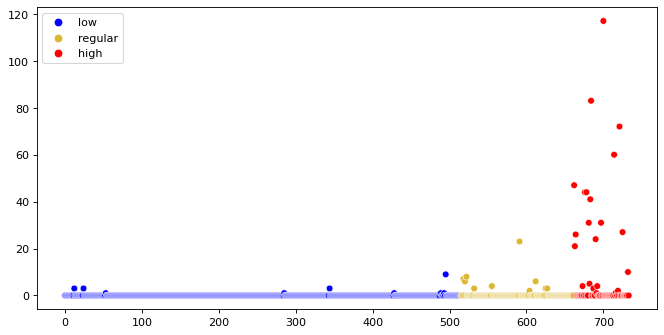

In [8]:
sub_df1 = df[['Method','CLevel_threshold', 'ChgLines']]
sub_df1 = sub_df1.sort_values(by=['CLevel_threshold'], key=lambda x: x.map(custom_dict), ignore_index=True)
sub_df1['method_idx'] = sub_df1.index

fig, ax = plt.subplots(figsize=(10,5), dpi= 80)
sns.scatterplot(data=sub_df1, x="method_idx", y="ChgLines", hue="CLevel_threshold", 
                palette={'low':'blue', 'regular':'#DCB732', 'high':'red'})
plt.legend(loc='upper left')
plt.xlabel("")
plt.ylabel("")
plt.savefig(plots_save_to_location + '/chg-lines_threshold.pdf', bbox_inches = 'tight', pad_inches = 0)

In [9]:
grouped_df1 = sub_df1.groupby('CLevel_threshold')
print(grouped_df1[['ChgLines']].sum())
grouped_df1[['ChgLines']].describe()

                  ChgLines
CLevel_threshold          
high                   698
low                     24
regular                 65


ChgLines                                                 
                    count      mean        std  min  25%  50%   75%    max
CLevel_threshold                                                          
high                 72.0  9.694444  22.162421  0.0  0.0  0.0  3.25  117.0
low                 515.0  0.046602   0.468630  0.0  0.0  0.0  0.00    9.0
regular             147.0  0.442177   2.239524  0.0  0.0  0.0  0.00   23.0

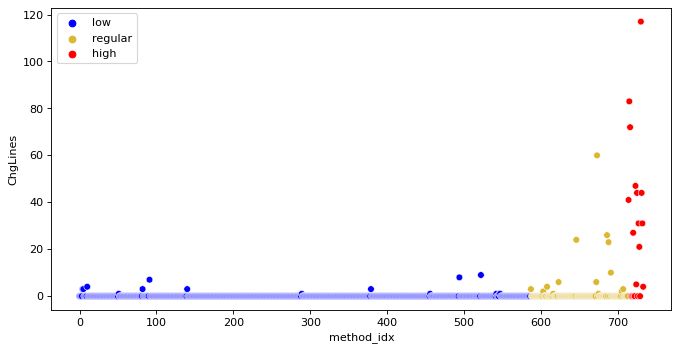

In [10]:
sub_df2 = df[['Method', 'CLevel_k_means', 'ChgLines']]
sub_df2 = sub_df2.sort_values(by=['CLevel_k_means'], key=lambda x: x.map(custom_dict), ignore_index=True)
sub_df2['method_idx'] = sub_df2.index

fig, ax = plt.subplots(figsize=(10,5), dpi= 80)
sns.scatterplot(data=sub_df2, x="method_idx", y="ChgLines", hue="CLevel_k_means", 
                palette={'low':'blue', 'regular':'#DCB732', 'high':'red'})
plt.legend(loc='upper left')
plt.savefig(plots_save_to_location + '/chg-lines_k_means.pdf', bbox_inches = 'tight', pad_inches = 0)

In [11]:
grouped_df2 = sub_df2.groupby('CLevel_k_means')
print(grouped_df2[['ChgLines']].sum())
grouped_df2[['ChgLines']].describe()

                ChgLines
CLevel_k_means          
high                 567
low                   49
regular              171


ChgLines                                                   
                  count       mean        std  min  25%   50%   75%    max
CLevel_k_means                                                            
high               20.0  28.350000  32.913403  0.0  0.0  24.0  44.0  117.0
low               587.0   0.083475   0.662127  0.0  0.0   0.0   0.0    9.0
regular           127.0   1.346457   6.526354  0.0  0.0   0.0   0.0   60.0

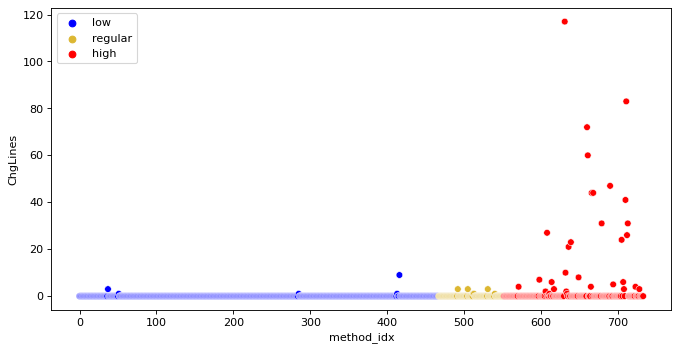

In [12]:
sub_df3 = df[['Method', 'CLevel_em', 'ChgLines']]
sub_df3 = sub_df3.sort_values(by=['CLevel_em'], key=lambda x: x.map(custom_dict), ignore_index=True)
sub_df3['method_idx'] = sub_df3.index

fig, ax = plt.subplots(figsize=(10,5), dpi= 80)
sns.scatterplot(data=sub_df3, x="method_idx", y="ChgLines", hue="CLevel_em", 
                palette={'low':'blue', 'regular':'#DCB732', 'high':'red'})
plt.legend(loc='upper left')
plt.savefig(plots_save_to_location + '/chg-lines_em.pdf', bbox_inches = 'tight', pad_inches = 0)

In [13]:
grouped_df3 = sub_df3.groupby('CLevel_em')
print(grouped_df3[['ChgLines']].sum())
grouped_df3[['ChgLines']].describe()

           ChgLines
CLevel_em          
high            760
low              15
regular          12


ChgLines                                                
             count      mean        std  min  25%  50%  75%    max
CLevel_em                                                         
high         182.0  4.175824  14.719922  0.0  0.0  0.0  0.0  117.0
low          467.0  0.032120   0.445575  0.0  0.0  0.0  0.0    9.0
regular       85.0  0.141176   0.580495  0.0  0.0  0.0  0.0    3.0

# Changed lines correlation with the other metrics

In [17]:
scaled_data = df.copy()
list_columns = ['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall', 'ChgLines']

for col_name in list_columns:
    col = scaled_data[col_name]
    min_col, max_col = col.min(), col.max()
#     min_col = 0  # consider min as 0 to perserve the importance of values; eg LOC 25, 50 -> 0.5, 1 
#     print(col_name, min_col, max_col)
    scaled_data[col_name] = (col - min_col) / (max_col - min_col)
    
scaled_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em,Previous_Method_Parsed,ChgLines
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),0.154762,0.029851,0.000000,0.022727,0.1,0.000000,0.025641,0.03125,0.000115,low,low,high,GES_GRT.GES_GRTCoreModule.PreInitialize(),0.000000
1,GES_GRT.GES_GRTCoreModule.Initialize(),0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000115,low,low,low,GES_GRT.GES_GRTCoreModule.Initialize(),0.000000
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),0.011905,0.000000,0.000000,0.000000,0.0,0.000000,0.012821,0.00000,0.000115,low,low,low,GES_GRT.GES_GRTCoreModule.PostInitialize(),0.000000
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,0.011905,0.000000,0.000000,0.000000,0.0,0.142857,0.000000,0.00000,0.106956,low,low,regular,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,0.000000
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),0.011905,0.000000,0.000000,0.000000,0.0,0.114286,0.000000,0.00000,0.068034,low,low,regular,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,0.083333,0.000000,0.071429,0.000000,0.0,0.028571,0.038462,0.09375,0.000115,low,low,high,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,0.000000
730,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.000000,0.029851,0.142857,0.000000,0.1,0.028571,0.025641,0.00000,0.000231,low,low,low,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.000000
731,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.000000,0.074627,0.142857,0.000000,0.1,0.028571,0.025641,0.00000,0.000231,low,low,high,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.000000
732,GES_GRT.Web.App.Startup.AppNavigationProvider....,0.011905,0.000000,0.071429,0.000000,0.0,0.000000,0.012821,0.43750,0.000115,regular,low,high,GES_GRT.Web.App.Startup.AppNavigationProvider....,0.059829


<AxesSubplot:>

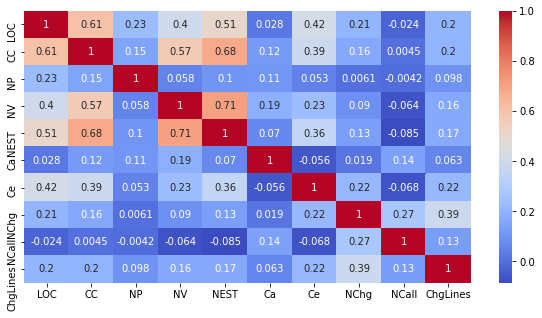

In [18]:
p_corr = scaled_data[list_columns].corr(method='kendall')
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(p_corr, xticklabels=p_corr.columns, yticklabels=p_corr.columns, annot=True, cmap='coolwarm', ax = ax)